In [64]:
import os
import pandas as pd
import pandas_gbq
import pytz
import io
import numpy as np
import seaborn as sns
from dbfread import DBF
import plotly as py
import plotly.graph_objects as go
import plotly.express as px 
import ipywidgets as widgets

In [63]:
#google cloud big query libraries
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = r"C:\Users\cday\tdm-scenarios-c90ba30c3c5d.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
 
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

### Read in Scenarios and Segment Summary Outputs

In [6]:
ScenarioTableID = 'tdm-scenarios.tdm_scenarios_output.scenarios'
scenarios = client.query("SELECT * FROM " + ScenarioTableID).to_dataframe()

SegmentTableID = 'tdm-scenarios.tdm_scenarios_output.segment_summary'
segment_summary = client.query("SELECT * FROM " + SegmentTableID).to_dataframe()

dfSegSum = pd.merge(segment_summary, scenarios, left_on = 'scenarioID', right_on = 'scenarioID', how = 'left')
dfSegSum = dfSegSum.sort_values('scenarioID')

## Create Graphics to show changes between 2 scenarios

In [ ]:
scenario1 = 4
scenario2 = 15

In [47]:
dfMean = dfSegSum.groupby('scenarioID').mean()

TypeError: ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

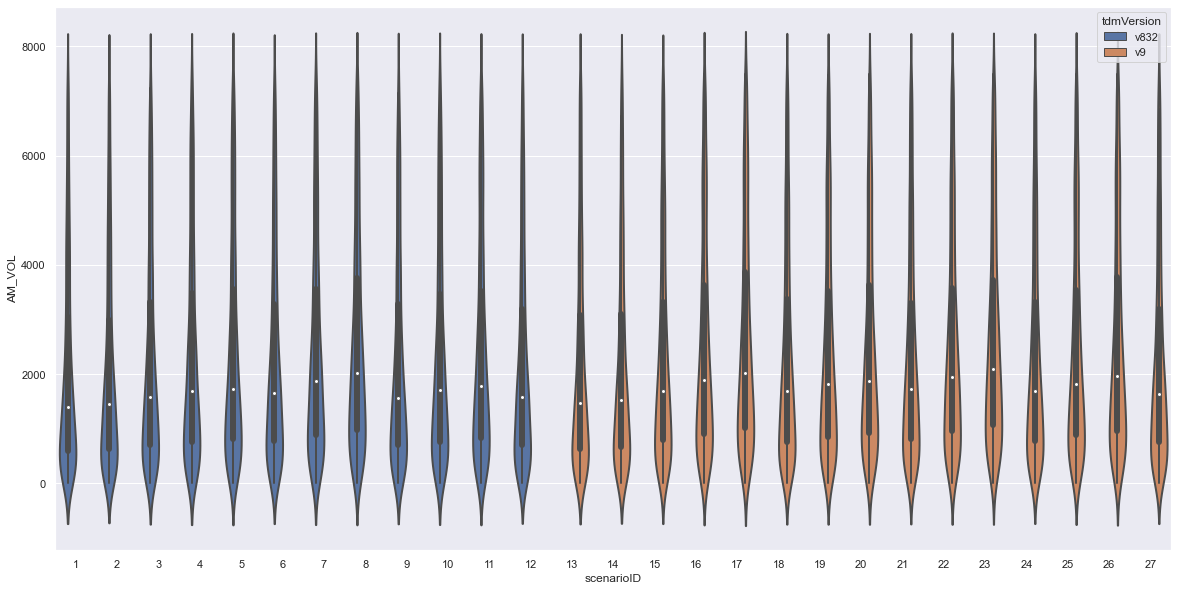

In [60]:
maxValue = 7500
sns.set(rc={'figure.figsize':(20,10)})

vp = sns.violinplot(data=dfSegSum, 
               x="scenarioID", 
               y=dfSegSum[dfSegSum["AM_VOL"]<maxValue]["AM_VOL"],
               hue ="tdmVersion",
               linewidth = 2,
               showfliers = False
              )
#g = sns.FacetGrid(dfSegSum, row="FT")
#g.map(sns.violinplot, 'AM_VOL', 'scenarioID')

### Summary Statistics using Violin Plots

In [118]:
def plot_violin(scenarioOptions, ftOptions, varOption):
    data = []
    for scenarios in scenarioOptions:
        for fts in ftOptions:
            # data for plotting from filtered dataframe
            if fts == 'All':
                plotdata = dfSegSum[(dfSegSum['scenarioID']==scenarios)]
            else:
                plotdata = dfSegSum[(dfSegSum['scenarioID']==scenarios) & (dfSegSum['FTCLASS']==fts)]
            plotdata = plotdata.fillna(0)

            trace1 =  go.Violin(
                x = plotdata['scenarioID'],
                y = plotdata[varOption],
                name = 'Scenario ' + str(scenarios),
                box_visible = True
            )
            data.append(trace1)
                
    layout2 = go.Layout(
        title='Segment Summary Stats for' +' FTCLASS: ' + fts,
        yaxis=dict(
            title='Amount'
        ),
        xaxis=dict(
            title='Scenarios'
        ),
        #width=1600,
        height=450
    )
    
    fig = go.Figure(data=data, layout=layout2)
    py.offline.iplot(data)

In [119]:
# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstFTType = dfSegSum['FTCLASS'].unique().tolist()
lstFTType.append('All')
lstScenario = list(set(dfSegSum.scenarioID.tolist()))
lstVars = ['DIST_1WY', 'LANES','CAP1HL', 'AM_VOL', 'MD_VOL', 'PM_VOL', 'EV_VOL', 'DY_VOL', 'DY_LT', 'DY_MD', 'DY_HV', 'FF_SPD', 'AM_SPD', 'MD_SPD', 'PM_SPD', 'EV_SPD', 'DY_SPD', 'D1_LINKS', 'D1_DIST', 'D1_LANES', 'D1_FT', 'D1_FTCLASS', 'D1_CAP1HL', 'D1_AM_VOL', 'D1_MD_VOL', 'D1_PM_VOL', 'D1_EV_VOL', 'D1_DY_VOL', 'D1_DY_LT', 'D1_DY_MD', 'D1_DY_HV', 'D1_FF_SPD', 'D1_AM_SPD', 'D1_MD_SPD', 'D1_PM_SPD', 'D1_EV_SPD', 'D1_DY_SPD', 'D2_LINKS', 'D2_DIST', 'D2_LANES', 'D2_FT', 'D2_FTCLASS', 'D2_CAP1HL', 'D2_AM_VOL', 'D2_MD_VOL', 'D2_PM_VOL', 'D2_EV_VOL', 'D2_DY_VOL', 'D2_DY_LT', 'D2_DY_MD', 'D2_DY_HV', 'D2_FF_SPD', 'D2_AM_SPD', 'D2_MD_SPD', 'D2_PM_SPD', 'D2_EV_SPD', 'D2_DY_SPD']
    
selectFTType       = widgets.SelectMultiple(options=lstFTType    , value=('Collector',)    , description='FTCLASS' )
selectScenario     = widgets.SelectMultiple(options=lstScenario  , value=(1 ,)             , description='Scenario')
selectVars         = widgets.Select        (options=lstVars      , value=('AM_VOL')        , description='Variable')

widgets.interactive(plot_violin, scenarioOptions = selectScenario, ftOptions = selectFTType, varOption = selectVars)

interactive(children=(SelectMultiple(description='Scenario', index=(0,), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 1…

### Summary Statistics using Maps